# Dielectric Function


part of 

## [Analysis of Transmission Electron Microscope Data](Analysis_of_Transmission_Electron_Microscope_Data.ipynb)

Chapter 4: [Spectroscopy](Diffraction.ipynb)

by Gerd Duscher


## Comparison to Optical Spectroscopy

The interaction of a transmitted electron with a solid is here described in terms of
a dielectric response function ε(q, ω). 

The same response function describes
the interaction of photons with a solid, so this formalism allows energy-loss data to
be compared with the results of optical measurements.

The difference is that there is no momentum transfer in an optical transition and therefore the relevant dielectric function is ε(q=0, ω).
$

The optical dielectric function (permittivity) is a transverse property of the medium, in the sense that the electric field of an electromagnetic wave displaces electrons in a direction perpendicular to the direction of propagation, the electron density remaining
unchanged. 

The relation between the ac conductivity $\sigma$ (for dc conductivity the in metals $\varepsilon$ can go to $\inf$ and is therefore not well described) and $\varepsilon$ is :
$$ \varepsilon = 1 + \frac{4\pi i \sigma}{\omega} $$

The relation between the complex refractive index $n+i\kappa$ and dielectric function is:
$$ n^2-\kappa^2 ={\bf Re}(\varepsilon), \ \ 2n\kappa = {\bf Im}(\varepsilon) $$

Optical absorption spectrum is obtained through
ABS= ${\bf Im}( \varepsilon(q→0,\omega) )$

So the dielectric function describes the electrical and optical response of a material almost completely. 



## Cross Section

$$ \frac{d^2\sigma}{dE d\Omega} = \frac{1}{\pi a_0 m_0 v^2 n_a} 
        {\rm Im} \left[ \frac{-1}{\varepsilon(q,E)} \right]
         \left( \frac{1}{\theta^2+\theta_E^2}\right)$$
         
The partial cross section  $\frac{d^2\sigma}{dE d\Omega}$ gives us the probability that an incident electron will be scattered into angle $q$ with energy-loss $E$.

There are three compenents, first a term that depens on the  atom density $n_a$ (atoms per volume).

And the third term is the (Lorentzian) angle dependence with the characteristic angle $$\theta = E_E/(\gamma m_0v^2)$$

The second term is the loss-function.

The loss function of a dielectric function $\varepsilon = \varepsilon_1+ i*\varepsilon_2$ is
$$ {\rm Im} \left[ \frac{-1}{\varepsilon(q,E)} \right] = \frac{\varepsilon_1(q,E)}{\varepsilon_1^2(q,E) + \varepsilon_2^2(q,E)}$$
At large energy loss and $q\approx 0$, $\varepsilon_2$ is small
and ε1 close to 1, the loss function becomes proportional to
ε2 and (apart from a factor of E−3) the energy-loss spectrum is proportional to the x-ray absorption spectrum.

# Thickness Determination

In [116]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook

from scipy import constants

Populating the interactive namespace from numpy and matplotlib


The probabaility of an low-loss function in a solid angle is then:
$$\frac{\partial^2 P}{(\partial E \partial \Omega) }= t*  \frac{e}{\pi^2 a_0 m_0 v^2} {\rm Im} \left[ \frac{-1}{\varepsilon(q,E)} \right]
         \left( \frac{1}{\theta^2+\theta_E^2}\right)$$
         
Please see [Kroeger Formalism](Kroeger.ipynb) for inclusion of retardation effects, and surface plasmons.

The integration over the (effective) collection angle gives:
$$\frac{\partial P}{\partial E} = \int_0^{\theta_c}\frac{\partial^2 P}{(\partial E \partial \Omega) }(E,\theta)\sin \theta\ d \theta$$

So we need to get the loss-function, calculate $\frac{\partial^2 P}{(\partial E \partial \Omega) }$ and then integrate over the angles, then we fit this to the spectrum with the sole variable of the thickness $t$.

The specimen thickness $t$, it is actually the total scattering
and mass thickness that is measured by EELS. If the physical density of a
material were reduced by a factor $ f$, the scattering per atom would remain the same
(according to an atomic model) and the mean free path should increase by a factor $f$.

The big problem hoewver, is that one has to know the **dielectric function**. 
In the case of the Drude theory, that means we need to know the electron density.

Any approximation therefore needs to approximate this dielectric function, which cannot be generally applicable.


# Relative Thickness

The relative thickness $ t_{rel} = t/\lambda$ is relative easy to determine. All the above problems are hidden in value of the inelatic mean free path (IMFP) $\lambda$, which is the inverse of the cross section above.

When you use a tabulated value for the IMFP, be aware that this value depends on:
 * acceleration voltage
 * effective collection angle
 * material density
 
and may not be applicable for your experimental setup.

### Angle dependence of relative thickness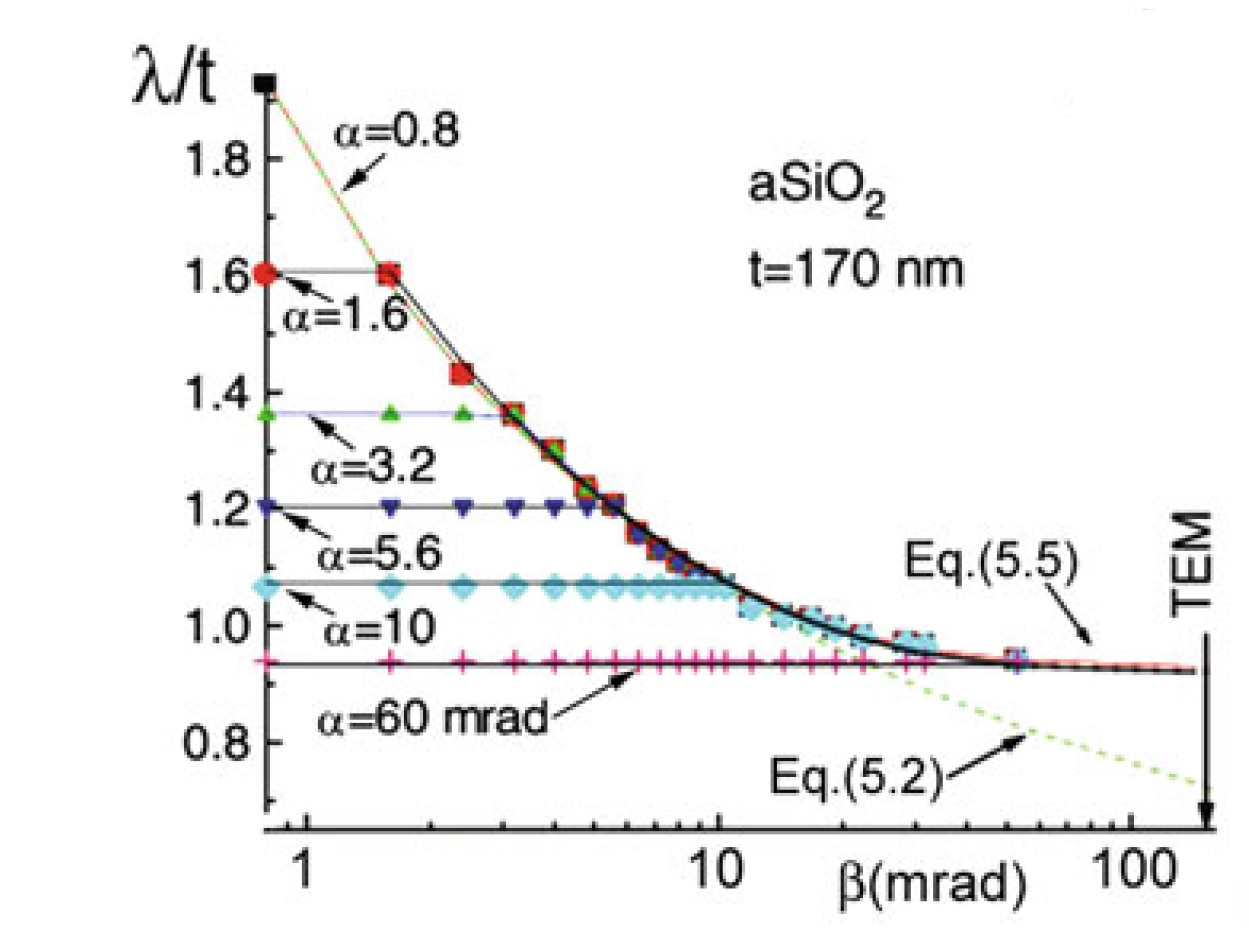


### Measurement of the relative thickness
The measurement of the relative thickness $t_{rel}$ is relative easy:

$$t_{rel}=t/\lambda = \log(I_0/I_{total})$$
with $I_0$ being the intensity of the zero loss peak, and $I_{total}$ the total intensity of the spectrum.

We already did this in the  [Fit Zero-Loss](FitZeroLoss.ipynb) part.


In [181]:
acceleration_voltage = 200 #in keV
collection_angle = 10 #mrad

def Drude(energy_scale, collection_angle, acceleration_voltage, thickness):
    #%Define constants
    m_0 = constants.value(u'electron mass') #% REST electron mass in kg
    
    h = constants.Planck #% Planck's constant
    hbar = constants.hbar;
    c = constants.speed_of_light #% speed of light m/s
    bohr = constants.value(u'Bohr radius'); #% Bohr radius in meters
    e = constants.value(u'elementary charge')#% electron charge in Coulomb

    #%Calculate fixed terms of equation
    va = 1 - (511./(511.+acceleration_voltage))**2; #% ee is incident energy in keV
    v = c*np.sqrt(va);
    beta =  v/c; # non relativistic for =1
    gamma = 1./np.sqrt(1-beta**2);
    momentum = m_0*v*gamma; #%used for xya, E&Bnhave no gamma 

    # Prefactor
    Pcoef = e/(bohr*np.pi*m_0*v**2);

    ##### Define mapped variables

    #%Define independant variables E, Theta
    ang = collection_angle *1e-3  #in rad
    adata = np.linspace(1e-20, ang,1024)
    dTheta = collection_angle*1e-3/1024*1024/50*256
    edata =  energy_scale
    [E,Theta] = np.meshgrid(edata+1e-12,adata);

    # characteristic angle
    ThetaE = E *e/ momentum / v;

    t = thickness * 1e-9 # nm 
    Ep = E_plasmon = 25
    plasmon_width = 5. 
    b = beta/1000.0 # %rad
    e0 = acceleration_voltage
    T = 1000.0*e0*(1.+e0/1022.12)/(1.0+e0/511.06)**2;# %eV # equ.5.2a or Appendix E p 427 
    tgt = 1000*e0*(1022.12 + e0)/(511.06 + e0);# %eV  Appendix E p 427 
    the = E/tgt; #% varies with energy loss! # Appendix E p 427 
    
    anglog = np.log(1.0+ ang*ang/the/the);
    
    eps =1 - E_plasmon**2/(energy_scale**2+2*energy_scale*plasmon_width*1j)
    elf = (-1/(1 - E_plasmon**2/(E**2+2*E*plasmon_width*1j))).imag
    volint = abs(thickness/(np.pi*0.05292*T*2.0)*(-1/eps)*anglog);
    print(volint.shape)
    print (eps.shape)
    dispersion_map = t * Pcoef * elf * (1/Theta+1/ThetaE)*np.sin(Theta)*dTheta

    spectrum_Drude = np.sum(dispersion_map, axis=0)
    return volint#spectrum_Drude

In [182]:

def Drude(energy_scale, collection_angle, acceleration_voltage, thickness):
    #%Define constants
    m_0 = constants.value(u'electron mass') #% REST electron mass in kg
    
    h = constants.Planck #% Planck's constant
    hbar = constants.hbar;
    c = constants.speed_of_light #% speed of light m/s
    bohr = constants.value(u'Bohr radius'); #% Bohr radius in meters
    e = constants.value(u'elementary charge')#% electron charge in Coulomb

    #%Calculate fixed terms of equation
    va = 1 - (511./(511.+acceleration_voltage))**2; #% ee is incident energy in keV
    v = c*np.sqrt(va);
    beta =  v/c; # non relativistic for =1
    gamma = 1./np.sqrt(1-beta**2);
    momentum = m_0*v*gamma; #%used for xya, E&Bnhave no gamma 

    # Prefactor
    Pcoef = e/(bohr*np.pi*m_0*v**2);

    ##### Define mapped variables

    #%Define independant variables E, Theta
    ang = collection_angle *1e-3  #in rad
    adata = np.linspace(1e-20, ang,1024)
    dTheta = collection_angle*1e-3/1024*1024/50*256
    edata =  energy_scale
    #[E,Theta] = np.meshgrid(edata+1e-12,adata);

    # characteristic angle
    #ThetaE = energy_scale *e/ momentum / v;

    ##t = thickness * 1e-9 # nm 
    Ep = E_plasmon = 25
    Ew = 5. 
    
    b = collection_angle/1000.0 # %rad
    e0 = acceleration_voltage
    
    
    T = 1000.0*e0*(1.+e0/1022.12)/(1.0+e0/511.06)**2;# %eV # equ.5.2a or Appendix E p 427 
    tgt = 1000*e0*(1022.12 + e0)/(511.06 + e0);# %eV  Appendix E p 427 
    the = energy_scale/tgt; #% varies with energy loss! # Appendix E p 427 
    
    anglog = np.log(1.0+ ang*ang/the/the);
    
    eps =1 - Ep**2/(energy_scale**2+2*energy_scale*Ew*1j)
    elf = (-1/eps).imag
    volint = abs(thickness/(np.pi*bohr*T*2.0)*elf*anglog);

    return volint#spectrum_Drude

c:\users\gduscher\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
c:\users\gduscher\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
c:\users\gduscher\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
c:\users\gduscher\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


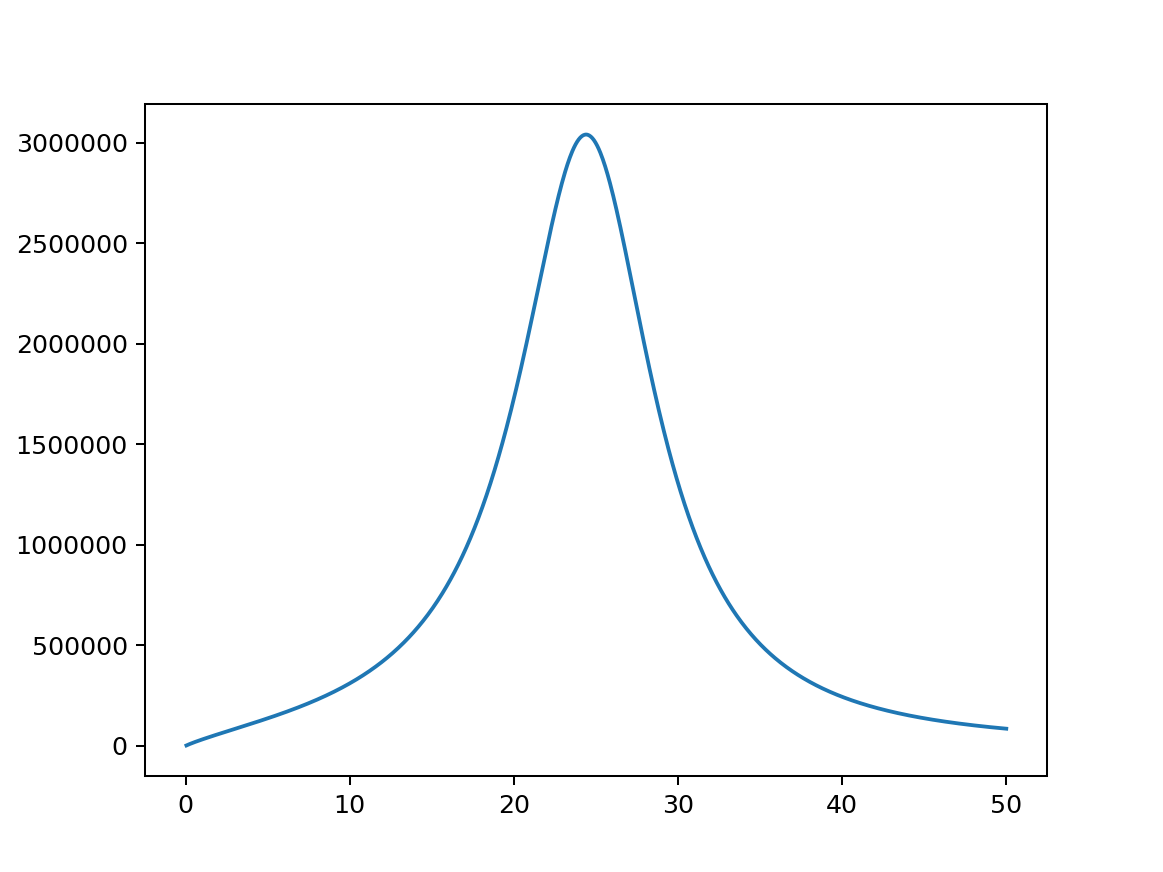

In [183]:

acceleration_voltage = 200 #in keV
collection_angle = 10 #mrad
thickness = 5 #in nm
energy_scale = np.linspace(0, 50,1024)


spectrum_Drude = Drude(energy_scale, collection_angle, acceleration_voltage,thickness)

plt.figure()
#plt.imshow((-1/eps).imag)
plt.plot(energy_scale, 1*spectrum_Drude)


In [131]:
print(8*4/0.5**3)
print (1/50*1024)

256.0
20.48
